In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import KFold

Import the csv file here

In [3]:
csv_path = "clv_predictions.csv"
df = pd.read_csv(csv_path)
df.head()

,customer_id,true_value,predicted_value,customer_segment,transaction_date
0,1001,1935.246582,1904.645470,New,2024-01-01
1,1002,4758.500101,4768.951518,Regular,2024-01-02
2,1003,3686.770315,3699.958576,Regular,2024-01-03
3,1004,3033.426573,3001.280759,New,2024-01-04
4,1005,864.491338,948.451191,New,2024-01-05


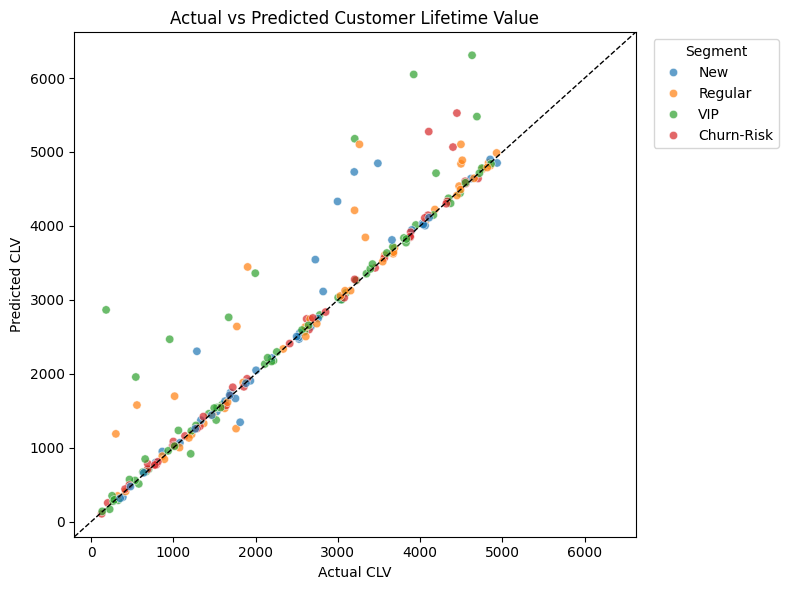

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df, x="true_value", y="predicted_value", hue="customer_segment", alpha=0.7, ax=ax)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, linestyle="--", color="black", linewidth=1)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title("Actual vs Predicted Customer Lifetime Value")
ax.set_xlabel("Actual CLV")
ax.set_ylabel("Predicted CLV")
ax.legend(title="Segment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23104\1531681873.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_errors, x="customer_segment", y="mean_absolute_error", palette="viridis", ax=ax)


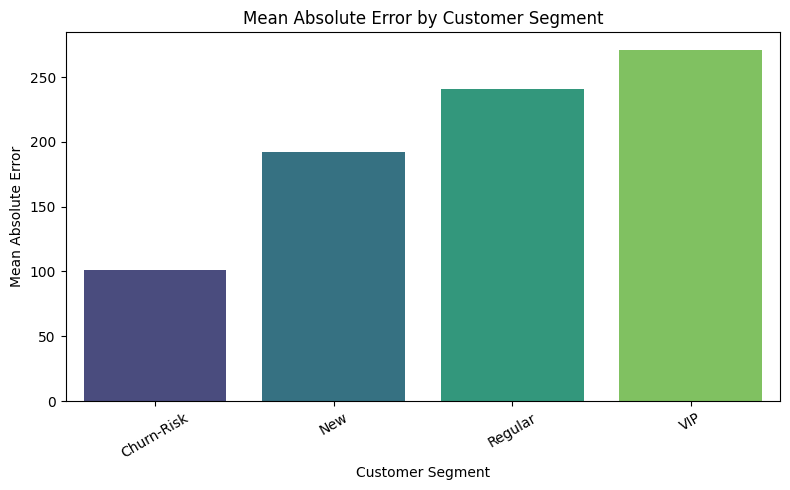

In [5]:
segment_errors = (
    df.assign(abs_error=(df["predicted_value"] - df["true_value"]).abs())
      .groupby("customer_segment", as_index=False)["abs_error"]
      .mean()
      .rename(columns={"abs_error": "mean_absolute_error"})
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=segment_errors, x="customer_segment", y="mean_absolute_error", palette="viridis", ax=ax)
ax.set_title("Mean Absolute Error by Customer Segment")
ax.set_xlabel("Customer Segment")
ax.set_ylabel("Mean Absolute Error")
ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

In [6]:
X = df.drop(columns=["true_value", "customer_id", "transaction_date"])
X = pd.get_dummies(X, columns=["customer_segment"], drop_first=True)
y = df["true_value"]

In [7]:
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [8]:
train_r2_scores = []
test_r2_scores = []
train_rmse_scores = []
test_rmse_scores = []

In [9]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [10]:
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    gb_model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = gb_model.predict(X_train)
    y_test_pred = gb_model.predict(X_test)
    
    # Calculate R² scores
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Calculate RMSE scores
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Store the metrics
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    
    # Print results for each fold
    
    print(f"Fold {fold}:")
    print(f"Training Set - R² Score: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Testing Set  - R² Score: {test_r2:.4f}, RMSE: {test_rmse:.4f}")

Fold 1:
  Train samples: 33, Test samples: 33
  Training Set - R² Score: 1.0000, RMSE: 2.5394
  Testing Set  - R² Score: 0.9952, RMSE: 103.8390

Fold 2:
  Train samples: 66, Test samples: 33
  Training Set - R² Score: 1.0000, RMSE: 6.5781
  Testing Set  - R² Score: 0.9977, RMSE: 68.9028

Fold 3:
  Train samples: 99, Test samples: 33
  Training Set - R² Score: 1.0000, RMSE: 9.9564
  Testing Set  - R² Score: 0.9980, RMSE: 66.0223

Fold 4:
  Train samples: 132, Test samples: 33
  Training Set - R² Score: 0.9999, RMSE: 15.5101
  Testing Set  - R² Score: 0.8359, RMSE: 557.7567

Fold 5:
  Train samples: 165, Test samples: 35
  Training Set - R² Score: 0.9993, RMSE: 36.9360
  Testing Set  - R² Score: 0.5688, RMSE: 946.1143



In [25]:
print(f"Average Training R² Score: {np.mean(train_r2_scores):.4f} (±{np.std(train_r2_scores):.4f})")
print(f"Average Testing R² Score: {np.mean(test_r2_scores):.4f} (±{np.std(test_r2_scores):.4f})")
print(f"Average Training RMSE: {np.mean(train_rmse_scores):.4f} (±{np.std(train_rmse_scores):.4f})")
print(f"Average Testing RMSE: {np.mean(test_rmse_scores):.4f} (±{np.std(test_rmse_scores):.4f})")

Average Training R² Score: 0.9892 (±0.0007)
Average Testing R² Score: 0.8715 (±0.0477)
Average Training RMSE: 149.5918 (±4.6941)
Average Testing RMSE: 505.3519 (±99.2779)
